# Prepare Dataset

### Download Data and Models

In [1]:
# To run the file, download data from: https://drive.google.com/drive/folders/1Rs68uH8Xqa4j6UxG53wzD0uyI8347dSq
!unzip -uq bd.zip -d data
!unzip -uq cl.zip -d data
!wget https://github.com/csaw-hackml/CSAW-HackML-2020/raw/master/lab3/models/bd_net.h5


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm



--2022-12-03 22:38:44--  https://github.com/csaw-hackml/CSAW-HackML-2020/raw/master/lab3/models/bd_net.h5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/csaw-hackml/CSAW-HackML-2020/master/lab3/models/bd_net.h5 [following]
--2022-12-03 22:38:45--  https://raw.githubusercontent.com/csaw-hackml/CSAW-HackML-2020/master/lab3/models/bd_net.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7275748 (6.9M) [application/octet-stream]
Saving to: ‘bd_net.h5.2’

bd_net.h5.2         100%[===================>]   6.94M  --.-KB/s    in 0.09s   

2022-12-03 22:38:45 (78.3 MB/s) - ‘bd_net.h5.2’ saved [7275748/7

#BadNets
The original badnet is shown and the accuracy and attack success rate for the original badnet will be printed out then.

###Load Data and Models


In [2]:
# path of the data
clean_data_filename = 'data/cl/valid.h5'
poisoned_data_filename = 'data/bd/bd_valid.h5'
model_filename = 'bd_net.h5'

#load the data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()


361/361 [==============================] - 3s 2ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 1s 2ms/step
Attack Success Rate: 100.0


In [3]:
model = keras.models.load_model(model_filename)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

VIsualizing the data to check the clean data

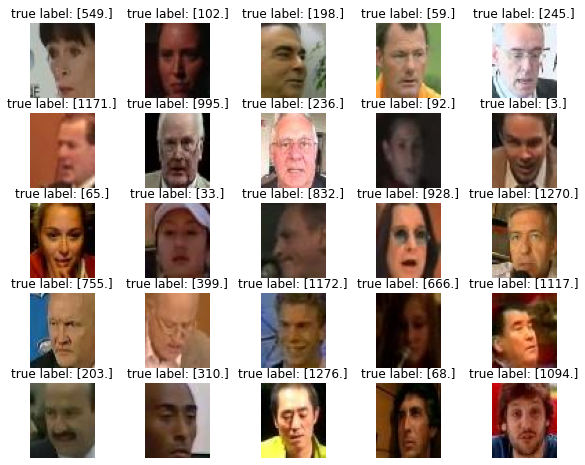

In [4]:
x_data, y_data = data_loader(clean_data_filename)
figure = plt.figure(figsize=(10,8))
cols, rows = 5,5
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

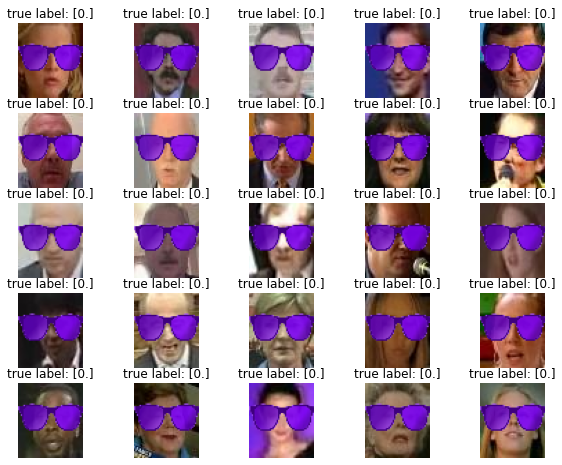

In [5]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)
figure = plt.figure(figsize=(10,8))
cols, rows = 5,5
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [6]:
# clearing the session
keras.backend.clear_session()

#Prune defense
Pruning the model in the following way:
1. The activation of the last pooling layer (pool_3) is checked.
2. The smallest average activation is ALWAYS pruned.
3. For convolution layer (conv_3), there are 60 channels in total and we need to get the index to prune.



In [7]:
# getting the data
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

In [8]:
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

# Getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('pruned_2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('pruned_4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('pruned_10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()

361/361 [==============================] - 1s 2ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 2ms/step


  2%|▏         | 1/60 [00:02<02:31,  2.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 1s 2ms/step


  3%|▎         | 2/60 [00:05<02:38,  2.73s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 1s 2ms/step


  5%|▌         | 3/60 [00:07<02:30,  2.64s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30


  7%|▋         | 4/60 [00:10<02:28,  2.65s/it]

361/361 [==============================] - 1s 2ms/step


  8%|▊         | 5/60 [00:13<02:29,  2.72s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  

 10%|█         | 6/60 [00:15<02:22,  2.64s/it]

98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 1s 2ms/step


 12%|█▏        | 7/60 [00:18<02:18,  2.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 1s 2ms/step


 13%|█▎        | 8/60 [00:21<02:16,  2.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 1s 2ms/step


 15%|█▌        | 9/60 [00:23<02:12,  2.59s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 1s 2ms/step


 17%|█▋        | 10/60 [00:26<02:08,  2.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25


 18%|█▊        | 11/60 [00:28<02:07,  2.60s/it]

361/361 [==============================] - 1s 2ms/step


 20%|██        | 12/60 [00:31<02:03,  2.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 1s 2ms/step


 22%|██▏       | 13/60 [00:33<01:59,  2.55s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 1s 2ms/step


 23%|██▎       | 14/60 [00:36<01:59,  2.60s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 1s 2ms/step


 25%|██▌       | 15/60 [00:39<01:55,  2.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47


 27%|██▋       | 16/60 [00:41<01:52,  2.55s/it]

361/361 [==============================] - 1s 2ms/step


 28%|██▊       | 17/60 [00:44<01:51,  2.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 1s 2ms/step


 30%|███       | 18/60 [00:46<01:49,  2.61s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 32%|███▏      | 19/60 [00:49<01:45,  2.58s/it]

361/361 [==============================] - 1s 2ms/step


 33%|███▎      | 20/60 [00:51<01:42,  2.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 1s 2ms/step


 35%|███▌      | 21/60 [00:54<01:39,  2.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 1s 2ms/step


 37%|███▋      | 22/60 [00:56<01:36,  2.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 38%|███▊      | 23/60 [00:59<01:35,  2.57s/it]

361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59


 40%|████      | 24/60 [01:02<01:31,  2.54s/it]

361/361 [==============================] - 1s 2ms/step


 42%|████▏     | 25/60 [01:04<01:28,  2.53s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 1s 2ms/step


 43%|████▎     | 26/60 [01:07<01:27,  2.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 1s 2ms/step


 45%|████▌     | 27/60 [01:09<01:26,  2.61s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 1s 2ms/step


 47%|████▋     | 28/60 [01:12<01:22,  2.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 1s 2ms/step


 48%|████▊     | 29/60 [01:15<01:19,  2.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 1s 2ms/step


 50%|█████     | 30/60 [01:17<01:17,  2.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 1s 2ms/step


 52%|█████▏    | 31/60 [01:20<01:14,  2.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 1s 2ms/step


 53%|█████▎    | 32/60 [01:22<01:12,  2.59s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 1s 2ms/step


 55%|█████▌    | 33/60 [01:25<01:09,  2.58s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 1s 2ms/step


 57%|█████▋    | 34/60 [01:27<01:06,  2.57s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
361/361 [==============================] - 1s 2ms/step


 58%|█████▊    | 35/60 [01:30<01:04,  2.59s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 1s 2ms/step


 60%|██████    | 36/60 [01:33<01:01,  2.56s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 1s 2ms/step


 62%|██████▏   | 37/60 [01:35<00:58,  2.55s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 1s 2ms/step


 63%|██████▎   | 38/60 [01:38<00:56,  2.59s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 1s 2ms/step


 65%|██████▌   | 39/60 [01:40<00:53,  2.56s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 1s 2ms/step


 67%|██████▋   | 40/60 [01:43<00:50,  2.53s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 1s 2ms/step


 68%|██████▊   | 41/60 [01:45<00:49,  2.59s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 1s 2ms/step


 70%|███████   | 42/60 [01:48<00:46,  2.56s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 1s 2ms/step


 72%|███████▏  | 43/60 [01:50<00:43,  2.54s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 1s 2ms/step


 73%|███████▎  | 44/60 [01:53<00:41,  2.58s/it]


The clean accuracy is:  97.51450593227679
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 1s 2ms/step


The accuracy drops at least 2%, saved the model
361/361 [==============================] - 1s 2ms/step


 75%|███████▌  | 45/60 [01:56<00:39,  2.61s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 1s 2ms/step


 77%|███████▋  | 46/60 [01:58<00:36,  2.57s/it]


The clean accuracy is:  95.21087728414307
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 1s 2ms/step


 78%|███████▊  | 47/60 [02:01<00:34,  2.64s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 1s 2ms/step


The accuracy drops at least 4%, saved the model
361/361 [==============================] - 1s 2ms/step


 80%|████████  | 48/60 [02:04<00:31,  2.61s/it]


The clean accuracy is:  92.10184463497012
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 1s 2ms/step


 82%|████████▏ | 49/60 [02:06<00:28,  2.58s/it]


The clean accuracy is:  91.48696631159609
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 1s 2ms/step


 83%|████████▎ | 50/60 [02:09<00:25,  2.60s/it]


The clean accuracy is:  91.02797263358448
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 1s 2ms/step


 85%|████████▌ | 51/60 [02:11<00:23,  2.57s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.78288733004243
The pruned channel index is:  11
361/361 [==============================] - 1s 2ms/step


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 1s 2ms/step


 87%|████████▋ | 52/60 [02:14<00:20,  2.57s/it]


The clean accuracy is:  84.45483675413527
The attack success rate is:  77.03299558326839
The pruned channel index is:  54
361/361 [==============================] - 1s 2ms/step


 88%|████████▊ | 53/60 [02:16<00:18,  2.60s/it]


The clean accuracy is:  76.47007880834849
The attack success rate is:  35.73222482029965
The pruned channel index is:  10
361/361 [==============================] - 1s 2ms/step


 90%|█████████ | 54/60 [02:19<00:15,  2.58s/it]


The clean accuracy is:  54.83675413527324
The attack success rate is:  6.980168009006668
The pruned channel index is:  28
361/361 [==============================] - 1s 2ms/step


 92%|█████████▏| 55/60 [02:22<00:12,  2.57s/it]


The clean accuracy is:  27.080627002684682
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 1s 2ms/step


 93%|█████████▎| 56/60 [02:24<00:10,  2.61s/it]


The clean accuracy is:  13.882393695332121
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 1s 2ms/step


 95%|█████████▌| 57/60 [02:27<00:07,  2.58s/it]


The clean accuracy is:  7.092751363990647
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 1s 2ms/step


 97%|█████████▋| 58/60 [02:29<00:05,  2.56s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 1s 2ms/step


 98%|█████████▊| 59/60 [02:32<00:02,  2.59s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 1s 2ms/step


100%|██████████| 60/60 [02:34<00:00,  2.58s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


In [9]:
print("Clean Classification Accuracy: ", clean_acc)
print("Backddor Attack Success Rate: ", asrate)

Clean Classification Accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.51450593227679, 95.75647354291158, 95.21087728414307, 94.7172425738287, 92.10184463497012, 91.48696631159609, 91.02797263358448, 89.17467740538669, 

Text(0.5, 1.0, 'Accuracy and Attack Success Rate for Validation Dataset')

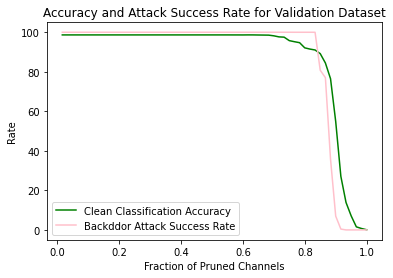

In [10]:
# Plot Accuracy and Attack Success Rate for Validation Dataset
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc, color = 'green')
plt.plot(x_axis,asrate, color = 'pink')
plt.legend(['Clean Classification Accuracy','Backddor Attack Success Rate'])
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Rate")
plt.title("Accuracy and Attack Success Rate for Validation Dataset")

In [11]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.980168009006668


#GoodNets
GoodNets model is the combination of original badnets model and pruned model. The goodNets will output the prediction if the prediction from BadNets model and the one from pruned model are the same.

In [12]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

##Evaluation of GoodNets Model


In [13]:
test_data_filename = 'data/cl/test.h5'
poisoned_test_data_filename = 'data/bd/bd_test.h5'
test_model_pruned_2_filename = '/content/pruned_2.h5'
test_model_pruned_4_filename = '/content/pruned_4.h5'
test_model_pruned_10_filename = '/content/pruned_10.h5'

In [14]:
test_model_pruned_2 = keras.models.load_model(test_model_pruned_2_filename)
test_model_pruned_4 = keras.models.load_model(test_model_pruned_4_filename)
test_model_pruned_10 = keras.models.load_model(test_model_pruned_10_filename)

In [15]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [16]:
G_model_pruned_2 = G(model, test_model_pruned_2)
G_model_pruned_4 = G(model, test_model_pruned_4)
G_model_pruned_10 = G(model, test_model_pruned_10)

##Evaluation on The Test Dataset


In [17]:
# For X={2%,4%,10%}, print out the clean test data classification accuracy and backdoor attack success rate
cl_test_2_label_p = np.argmax(test_model_pruned_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, The Clean Test Data Classification Accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_pruned_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Backdoor Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_pruned_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, The Clean Test Data Classification Accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_pruned_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Backdoor Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_pruned_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, The Clean Test Data Classification Accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_pruned_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, BackdoorAttack Success Rate:', asr_10)

401/401 [==============================] - 1s 2ms/step
2% drops model, The Clean Test Data Classification Accuracy: 95.90802805923616
401/401 [==============================] - 1s 2ms/step
2% drops model, Backdoor Attack Success Rate: 100.0
401/401 [==============================] - 1s 2ms/step
4% drops model, The Clean Test Data Classification Accuracy: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
4% drops model, Backdoor Attack Success Rate: 99.98441153546376
401/401 [==============================] - 1s 2ms/step
10% drops model, The Clean Test Data Classification Accuracy: 84.54403741231489
401/401 [==============================] - 1s 2ms/step
10% drops model, BackdoorAttack Success Rate: 77.23304754481684


##Summarization of The Fixed Models


In [18]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.908028,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.233048


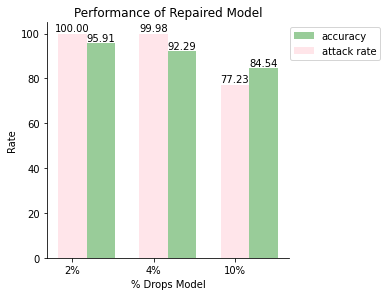

In [19]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% Drops Model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='green', label='Accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='pink', label='Attack Rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of Repaired Model')
sns.despine()
plt.show()

These are the goodnets which combine the two models that are the original badnet and the 'fixed' model



In [20]:
G_cl_test_2_label_p = G_model_pruned_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, The Clean Test Data Classification Accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_pruned_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Backdoor Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_pruned_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, The Clean Test Data Classification Accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_pruned_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Backdoor Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_pruned_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, The Clean Test Data Classification Accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_pruned_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Backdoor Attack Success Rate:', G_asr_10)

Combined 2% drops model, The Clean Test Data Classification Accuracy: 95.90802805923616
Combined 2% drops model, Backdoor Attack Success Rate: 100.0
Combined 4% drops model, The Clean Test Data Classification Accuracy: 92.29150428682775
Combined 4% drops model, Backdoor Attack Success Rate: 99.98441153546376
Combined 10% drops model, The Clean Test Data Classification Accuracy: 84.54403741231489
Combined 10% drops model, Backdoor Attack Success Rate: 77.23304754481684


In [21]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.908028,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.233048


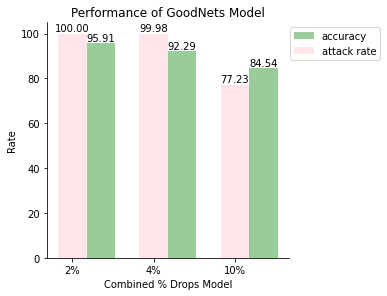

In [22]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('Combined % Drops Model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='green', label='Accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='pink', label='Attack Rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of GoodNets Model')
sns.despine()
plt.show()

#Conclusion

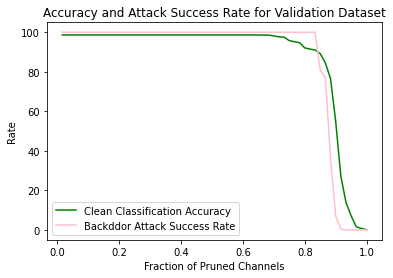

From the start, before pruning the defense, the accuracy is 98.65 and the attack success rate is 100.0. From the evaluation section, we can see that if we prune the channels slightly, the effect is not very obvious. As the number of pruned channels increases, the attack success rate decreases. When we trim a large number of channels, the attack success rate decreases a lot. However, the accuracy rate also decreases a lot. In addition, from the figure above, we can see that there is no large "green space" such as the space in the picture below. That is, the backdoor is enabled at the expense of the accuracy of the clean set. Therefore, I think that the pruning defense does not actually work for this model. This is probably because the attacker (this bd_model) adapts to this defense, i.e., the adaptive attacker introduces sacrificial neurons in the network to disable the pruning defense. This is why we do not see a significant effect of our defense approach.

Example from Lecture Slides:
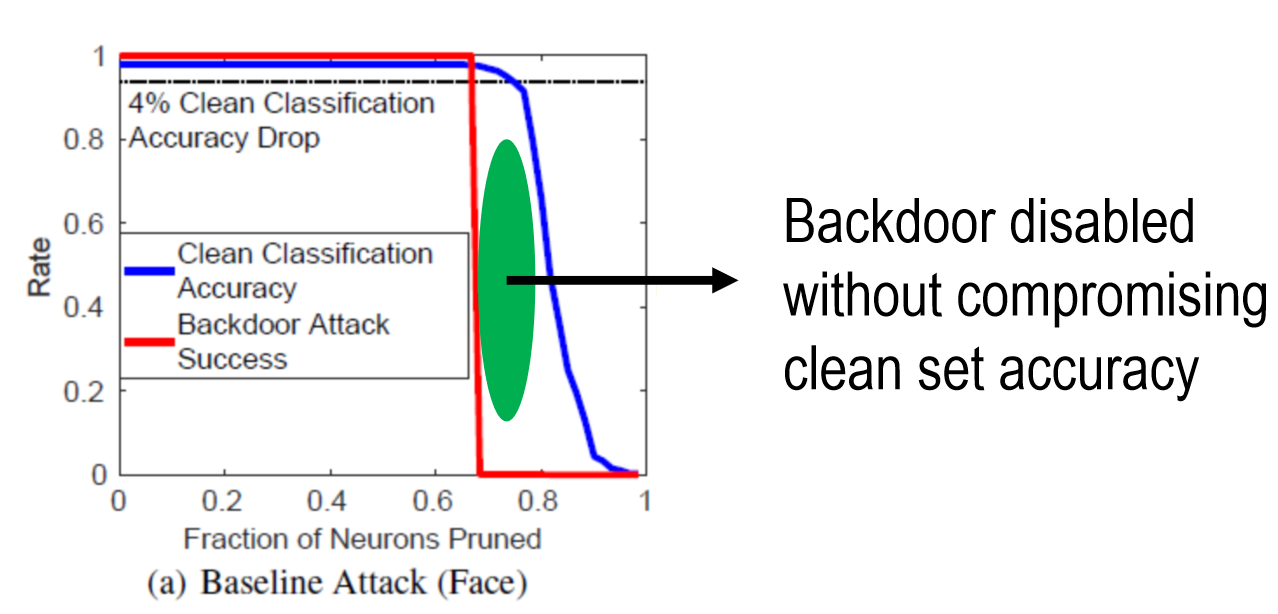